In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

# Explore Train Data

## Loading the datasets

In [2]:
df_train = pd.read_csv("../data/raw/data_train.csv.gz")
df_test = pd.read_csv("../data/raw/data_test.csv.gz")

In [3]:
df_train.head()

,product_id,category_id,f0,f1,f2,f3,f4,f5,f6,f7,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,cdc53c8374034e8d41528375097a51c087390292,2081,-0.006559,-0.120659,-0.004383,0.007749,-0.037135,-0.039693,-0.000479,-0.009981,...,0.012074,-0.002464,-0.005398,0.002239,-0.010406,-0.008286,0.007256,0.003646,0.007139,-0.011185
1,7faed7269ff5e13ced9245d23e88cb17e8b4c91b,9820,0.101763,-0.018803,-0.027987,-0.043492,0.096025,0.016519,0.010036,-0.015817,...,-0.001446,-0.002490,-0.006619,-0.018201,-0.025073,-0.019518,0.002237,-0.003276,-0.000349,0.008102
2,c307ce173cac526708f00f509d5250af69e2adcf,15651,-0.040672,-0.078895,-0.051821,-0.011871,-0.020762,0.041655,-0.059276,-0.022324,...,0.005634,-0.000398,0.003627,0.019286,0.005602,-0.009435,0.003241,-0.014601,-0.019980,0.015251
3,49b52f955911fafc4ddc136debb974070568551d,3056,-0.105920,0.043751,0.004357,0.085637,0.011778,-0.019016,-0.083128,0.025109,...,-0.020314,0.001298,0.012358,-0.006352,0.000958,-0.006532,-0.007828,-0.016894,0.004076,0.001585
4,0999ed1b31922ffee4f82526c5069f70d231960e,6933,-0.008389,-0.028736,-0.005999,0.047041,0.011757,-0.037296,-0.033031,0.056991,...,-0.007202,0.006544,-0.006674,0.004217,-0.000845,0.004107,0.001433,-0.003491,-0.016566,0.019101


In [4]:
print(f"{df_train.category_id.nunique()} unique categories in trainset")
print(f"{df_test.category_id.nunique()} unique categories in testset")

101 unique categories in trainset
101 unique categories in testset


In [26]:
categories_repartition = df_train.category_id.value_counts(normalize=True).to_frame().join(df_test.category_id.value_counts(normalize=True).to_frame(), lsuffix="_train", rsuffix="_test")

<AxesSubplot: >

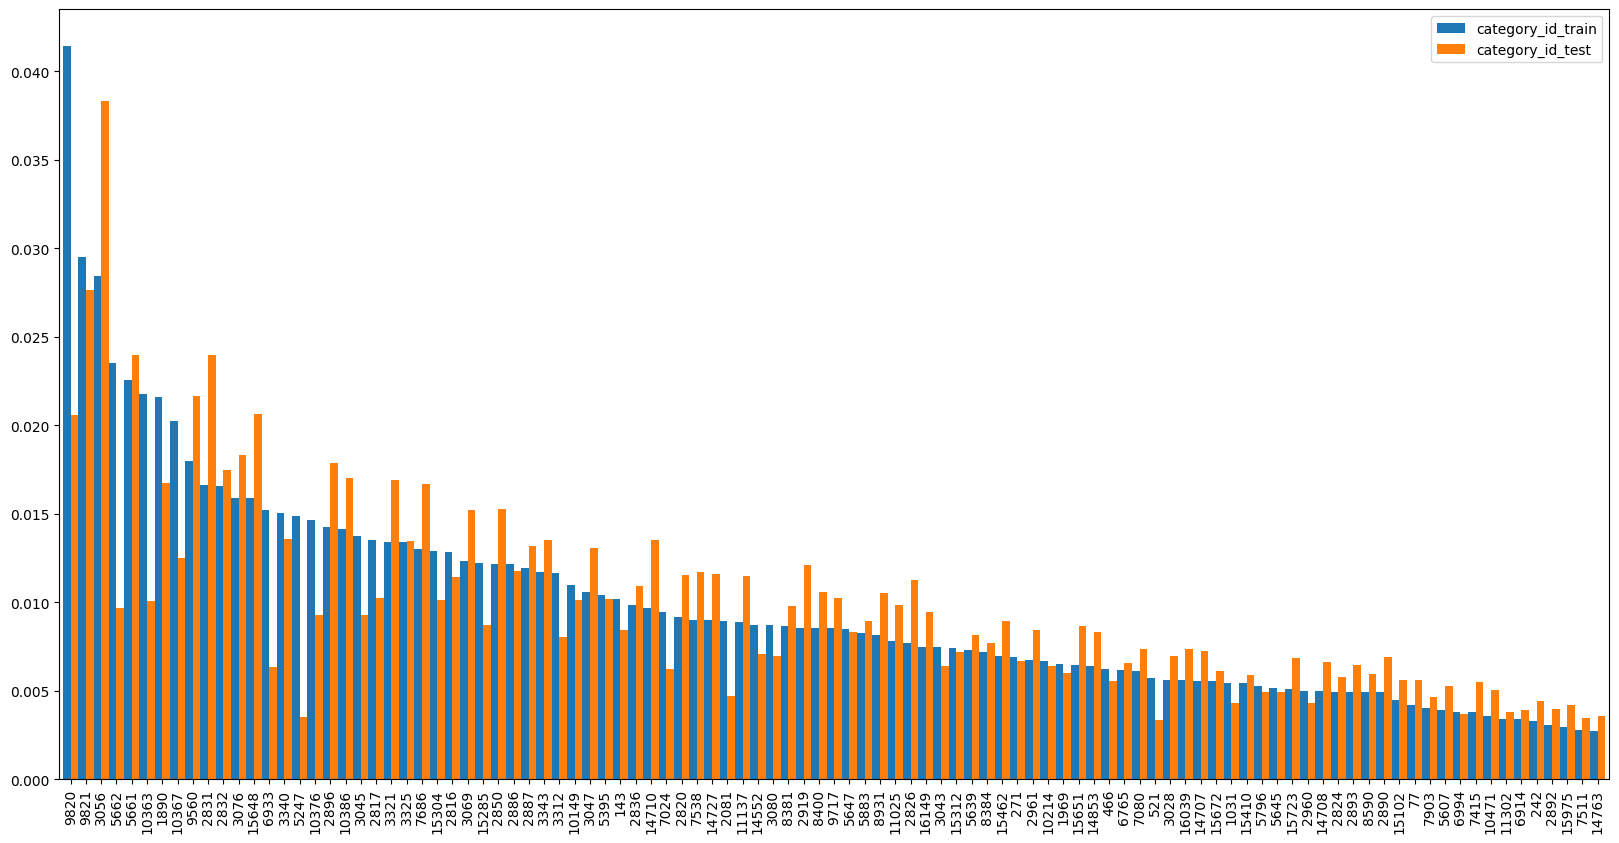

In [27]:
categories_repartition.plot.bar(width=1)

In [28]:
df_train[[f'f{x}' for x in range(128)]].max().sort_values()

f120      0.093514
f125      0.098582
f123      0.102829
f126      0.106333
f104      0.109370
           ...    
f6        0.449142
f1        0.455026
f4        0.459381
f0        0.478981
f100    101.678658
Length: 128, dtype: float64

<AxesSubplot: ylabel='Density'>

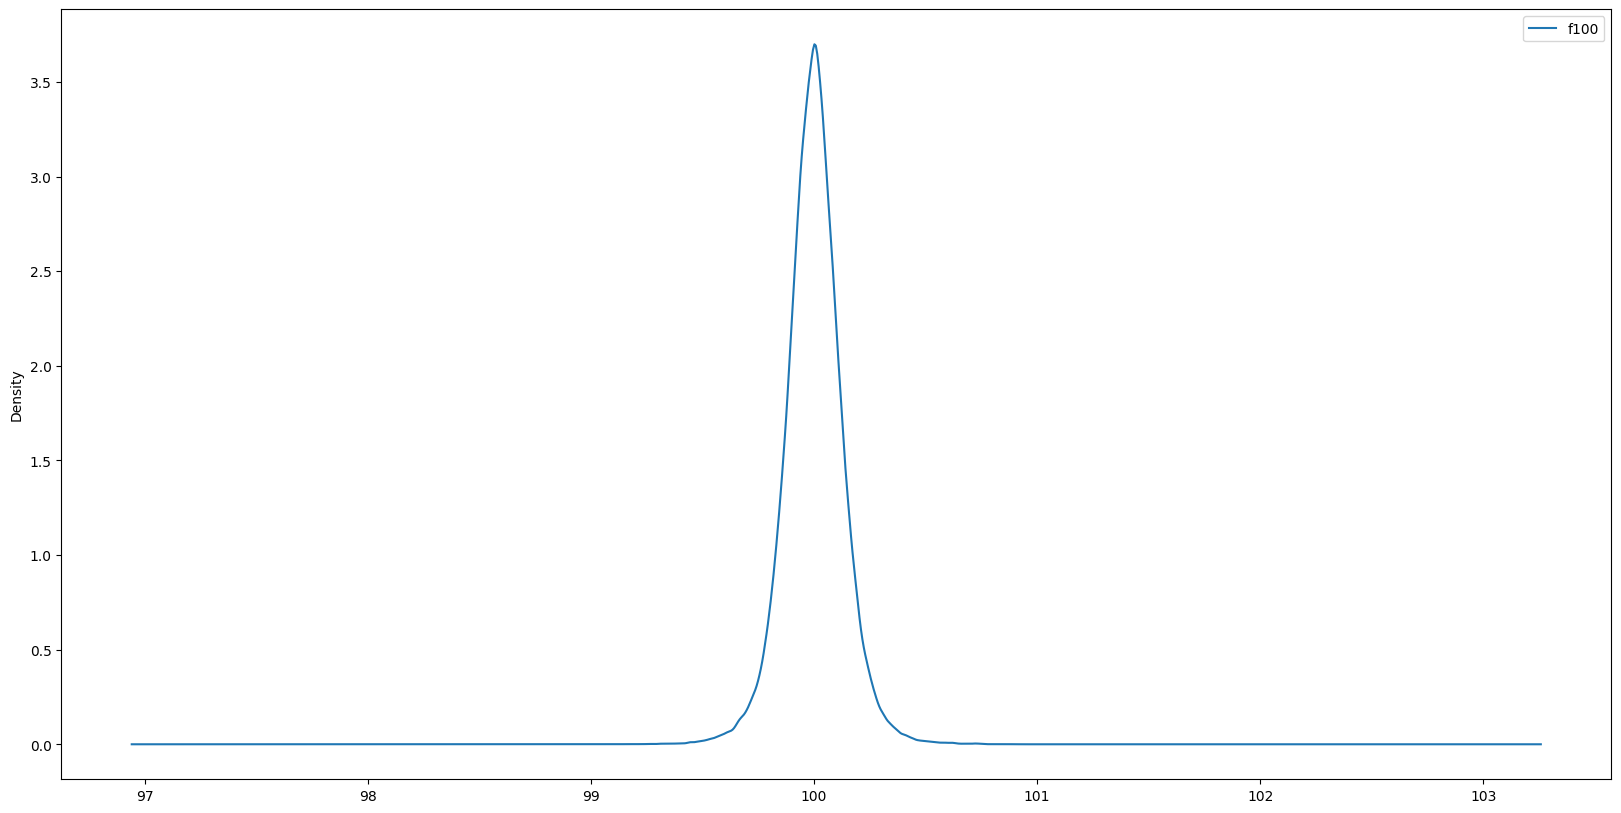

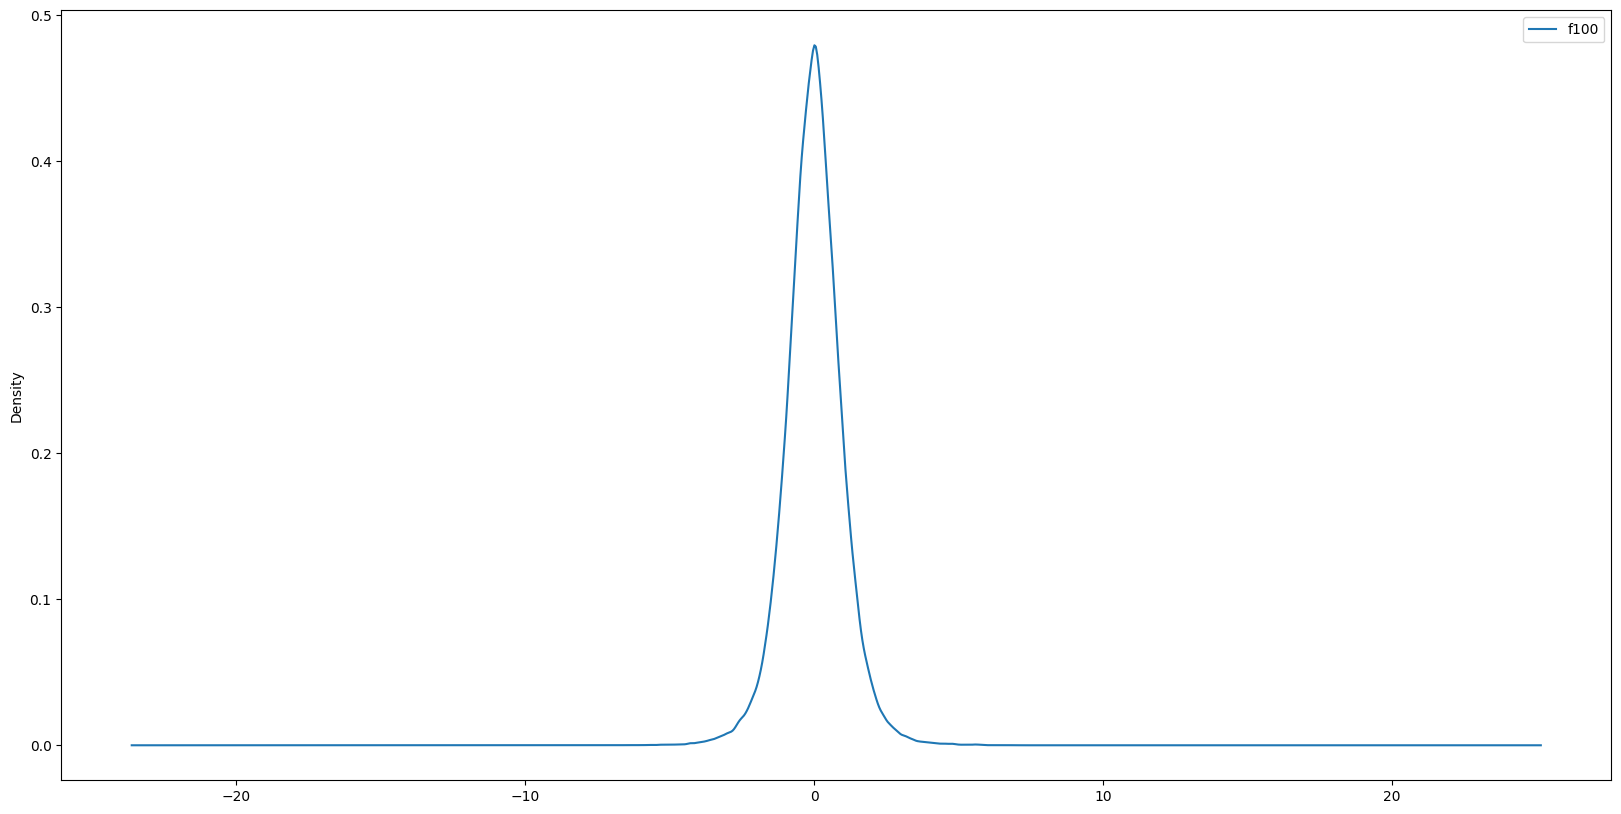

In [29]:
(df_train[['f100']]).plot(kind='kde')
((df_train[['f100']]-df_train[['f100']].mean())/df_train[['f100']].std()).plot(kind='kde')

<AxesSubplot: ylabel='Density'>

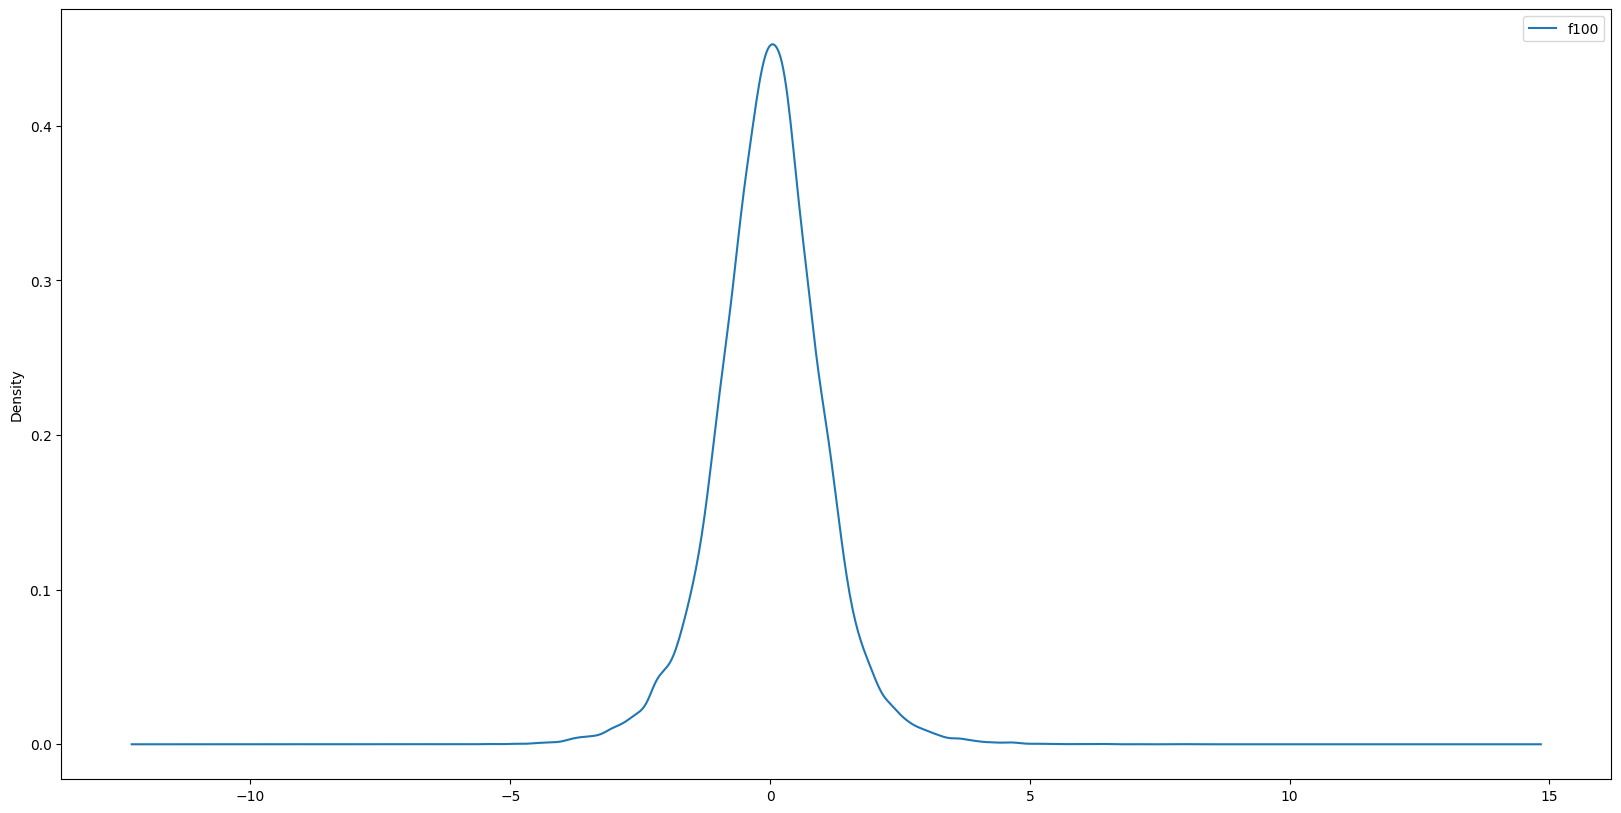

In [30]:
((df_test[['f100']]-df_train[['f100']].mean())/df_train[['f100']].std()).plot(kind='kde')

In [31]:
df_train[['f100']] = (df_train[['f100']]-df_train[['f100']].mean())/df_train[['f100']].std() 

# Explore Categories

In [32]:
df_categories = pd.read_csv("../data/raw/category_parent.csv")

In [33]:
df_categories

,category_id,parent_id
0,-1,NaN
1,64,63.0
2,65,64.0
3,77,65.0
4,1876,1855.0
...,...,...
263,10906,-1.0
264,14394,-1.0
265,15201,-1.0
266,15645,-1.0


In [34]:
import pandas as pd
import numpy as np
import igraph as ig
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

df_category = df_category = pd.read_csv("../data/raw/category_parent.csv").dropna()
df_category['parent_id'] = df_category['parent_id'].replace(-1, 0)
df_category['parent_id'] = df_category['parent_id'].astype(int)
df_category['category_id'] = df_category['category_id'].astype(int)

codes, uniques = pd.factorize(list(df_category['category_id'].values))
new_root_id = len(uniques)
df_category['parent_id'] = df_category['parent_id'].apply(lambda x: list(uniques).index(x) if x != 0 else new_root_id)
df_category['category_id'] = codes

    
# Ensure all parent_id and category_id are represented as vertices
all_nodes = pd.concat([df_category['category_id'], df_category['parent_id'].dropna()]).unique()

# 1. Create a graph using igraph and add all vertices
G = ig.Graph(directed=True)
G.add_vertices([int(node) for node in all_nodes])

# 2. Add edges based on the parent-child relationship (ensure proper mapping)
edges = df_category.dropna(subset=['parent_id'])[['category_id', 'parent_id']].values

# Before adding edges, ensure the edges reference valid vertex IDs
valid_edges = [(int(edge[1]), int(edge[0])) for edge in edges if int(edge[1]) in all_nodes and int(edge[0]) in all_nodes]
G.add_edges(valid_edges)

# 3. Generate layout for the graph (e.g., tree layout)
layout = G.layout_reingold_tilford(root=[new_root_id])

# Get x, y coordinates from the layout
coords = {v['name']: layout[i] for i, v in enumerate(G.vs)}

# Extract x and y for each node
x_coords = [coords[node][0] for node in all_nodes]
y_coords = [-coords[node][1] for node in all_nodes]

# 4. Create a scatter plot for nodes
scatter_nodes = go.Scatter(
    x=x_coords,
    y=y_coords,
    mode='markers+text',
    text=[f'{uniques[node]}' if node != new_root_id else 'Root' for node in all_nodes],
    textposition='top center',
    hoverinfo='text',
      name='category',
      marker=dict(symbol='circle-dot',
                    size=18,
                    color='#6175c1',    #'#DB4551',
                    line=dict(color='rgb(50,50,50)', width=1)
                    ),
      opacity=0.8
)

# 5. Create edges between parent and child nodes
edge_x = []
edge_y = []
for edge in G.es:
    source, target = edge.tuple
    edge_x += [coords[G.vs[source]['name']][0], coords[G.vs[target]['name']][0], None]
    edge_y += [-coords[G.vs[source]['name']][1], -coords[G.vs[target]['name']][1], None]

# Create line traces for edges
scatter_edges = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=2, color='gray'),
    hoverinfo='none'
)

# 6. Combine nodes and edges into a single plot
fig = go.Figure(data=[scatter_edges, scatter_nodes])

# Customize layout
fig.update_layout(
    title="Category Hierarchy Tree",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
        width=1100,  # Set the width of the plot
    height=600   # Set the height of the plot
)

# Show the plot
import plotly.io as pio

# Show the figure in a new tab
pio.show(fig)

In [35]:
g = G
nodes_with_multiple_parents = []

# Iterate through each vertex (node)
for v in g.vs:
    # Get the list of incoming edges to this vertex
    incoming_edges = g.incident(v, mode="IN")
    
    # Count the number of parents (incoming edges)
    if len(incoming_edges) > 1:
        nodes_with_multiple_parents.append(v.index)

# Output the result
print("Nodes with multiple parents:", nodes_with_multiple_parents)

Nodes with multiple parents: []


In [36]:
# Compute the degree of each node
degrees = G.degree()
num_leaves = sum(1 for d in degrees if d == 1)

# Output the number of leaves
print(f"Number of leaves: {num_leaves}")

invalid_nodes_by_degree = [G.vs[i]['name'] for i, d in enumerate(G.degree()) if d == 0]

print(f"Invalid nodes by degree (no connections):\n{invalid_nodes_by_degree}")

Number of leaves: 101
Invalid nodes by degree (no connections):
[]


### Outliers detection

In [49]:
features = df_train.drop(['product_id', 'category_id'], axis = 1)
features = np.array(features)

features_test = df_test.drop(['product_id', 'category_id'], axis = 1)
features_test = np.array(features_test) 

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=13)

In [39]:
pca.fit(features)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.92229736 0.01061867 0.00744857 0.00466133 0.0037301  0.00290957
 0.00258133 0.00215852 0.00185926 0.00163956 0.00152473 0.00127519
 0.00123149]
0.9639356607247505


In [50]:
pca = PCA(n_components=2)
pca.fit(features)
projections = pca.transform(features)
projections_df = pd.DataFrame(data=projections)

projections_test = pca.transform(features_test)
projections_test_df = pd.DataFrame(data=projections_test)

<AxesSubplot: xlabel='0'>

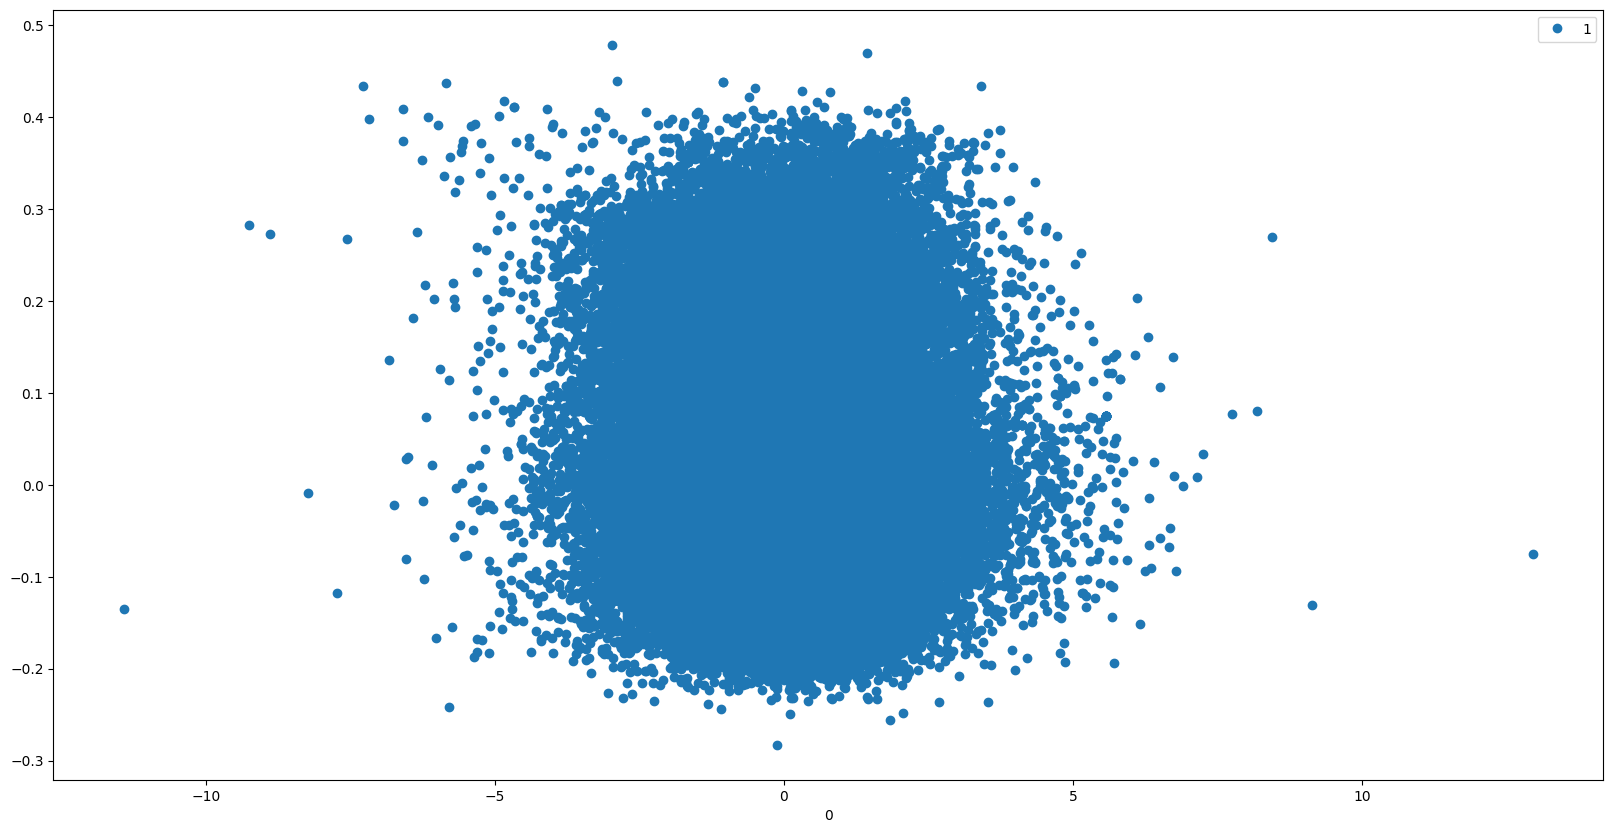

In [53]:
projections_df.plot(x=projections_df.columns[0], y=projections_df.columns[1],style='o')

<AxesSubplot: xlabel='0'>

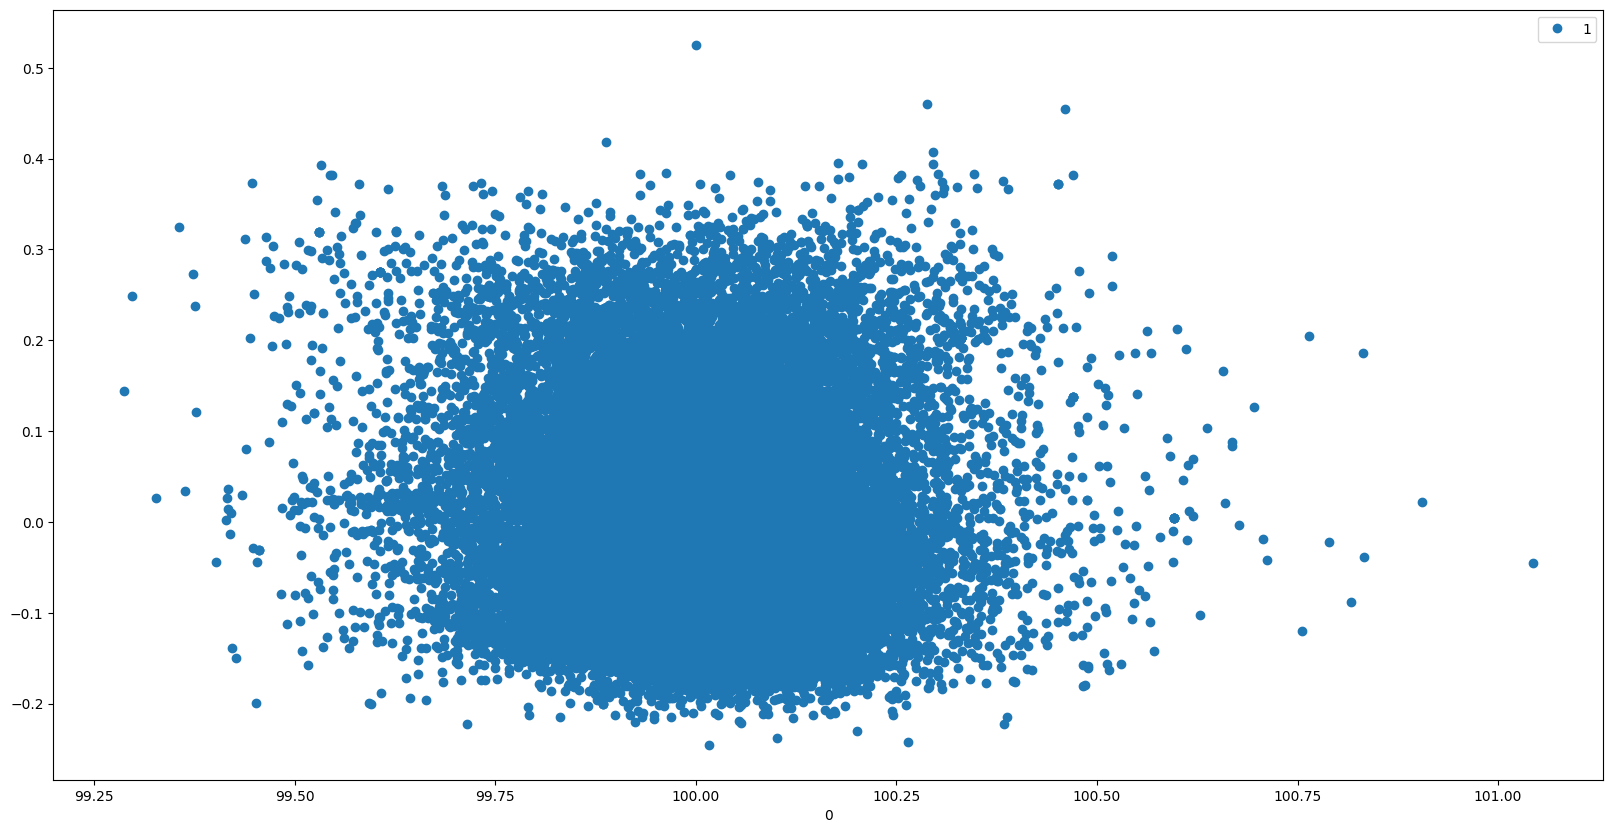

In [55]:
projections_test_df.plot(x=projections_test_df.columns[0], y=projections_test_df.columns[1],style='o')

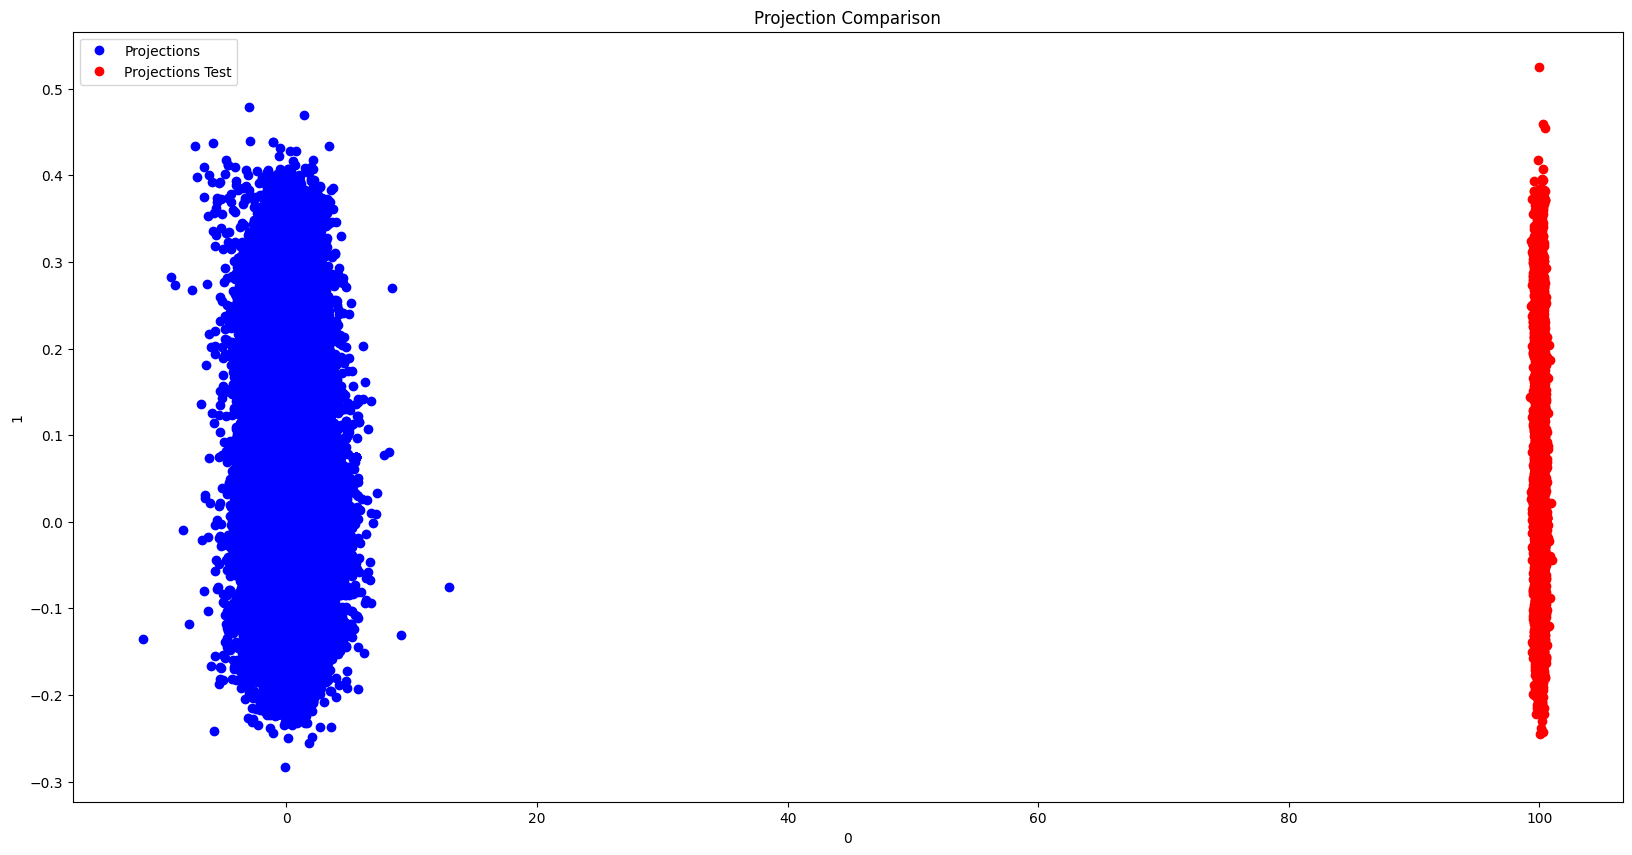

In [54]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the first DataFrame with one color (e.g., blue)
ax.plot(
    projections_df[projections_df.columns[0]],
    projections_df[projections_df.columns[1]],
    'o', color='blue', label='Projections'
)

# Plot the second DataFrame with a different color (e.g., red)
ax.plot(
    projections_test_df[projections_test_df.columns[0]],
    projections_test_df[projections_test_df.columns[1]],
    'o', color='red', label='Projections Test'
)

# Add labels, legend, and title for clarity
ax.set_xlabel(projections_df.columns[0])
ax.set_ylabel(projections_df.columns[1])
ax.legend()
plt.title("Projection Comparison")

# Show the plot
plt.show()

In [59]:
df_train_norm = pd.concat([
    pd.read_parquet("../data/processed/train.parquet"),
    pd.read_parquet("../data/processed/eval.parquet")
])
df_test_norm = pd.read_parquet("../data/processed/test.parquet")

In [62]:
features = df_train_norm.drop(['product_id', 'category_id'], axis = 1)
features = np.array(features)

features_test = df_test_norm.drop(['product_id', 'category_id'], axis = 1)
features_test = np.array(features_test) 

pca = PCA(n_components=2)
pca.fit(features)
projections = pca.transform(features)
projections_df = pd.DataFrame(data=projections)

projections_test = pca.transform(features_test)
projections_test_df = pd.DataFrame(data=projections_test)

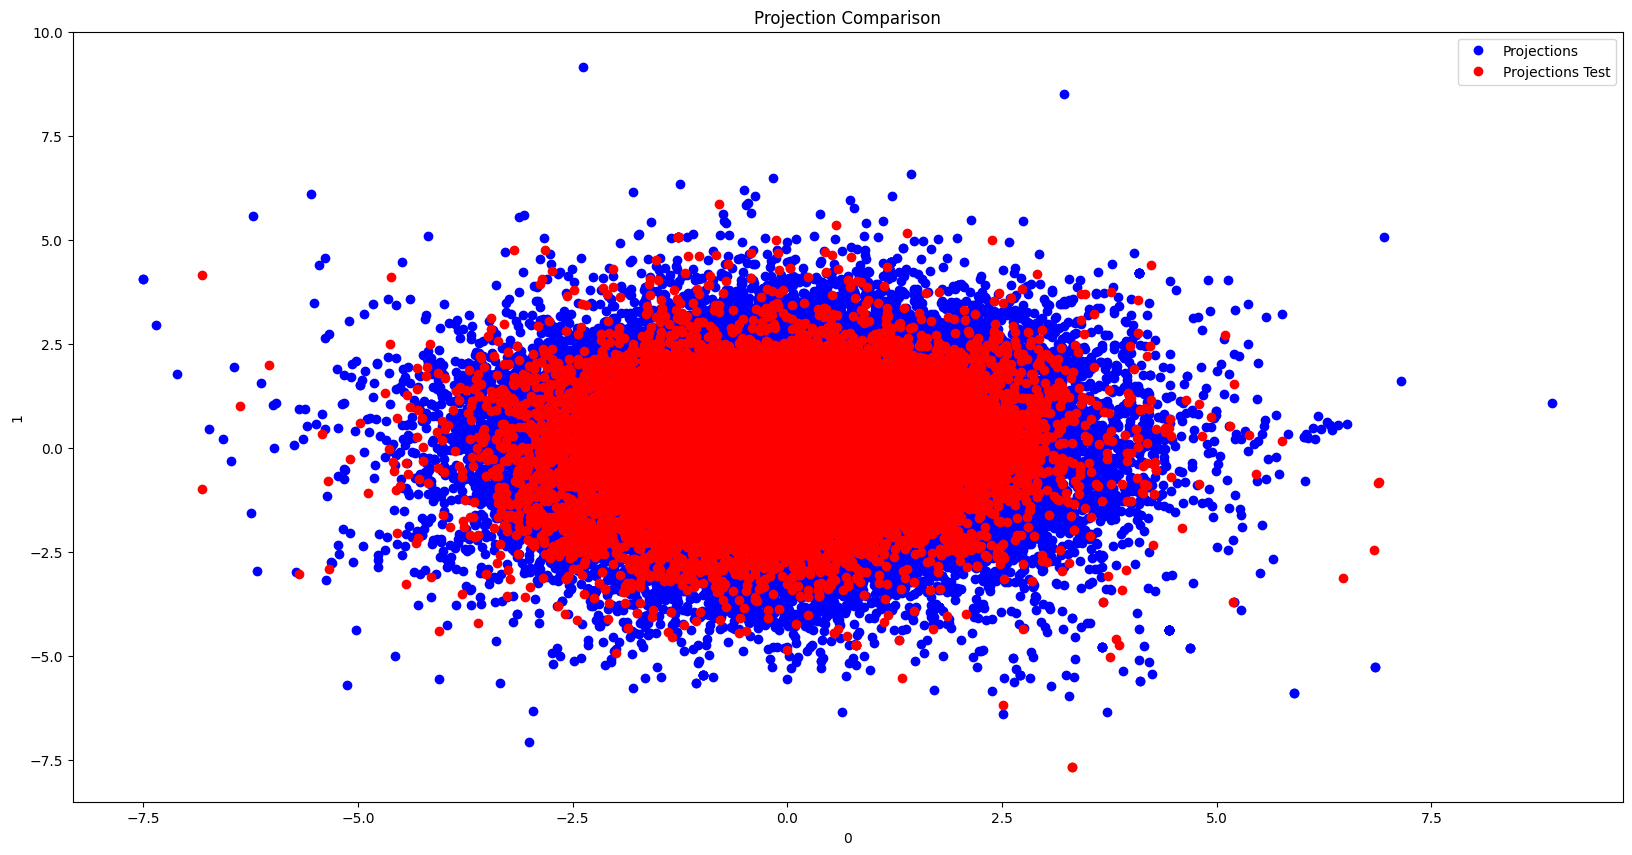

In [63]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the first DataFrame with one color (e.g., blue)
ax.plot(
    projections_df[projections_df.columns[0]],
    projections_df[projections_df.columns[1]],
    'o', color='blue', label='Projections'
)

# Plot the second DataFrame with a different color (e.g., red)
ax.plot(
    projections_test_df[projections_test_df.columns[0]],
    projections_test_df[projections_test_df.columns[1]],
    'o', color='red', label='Projections Test'
)

# Add labels, legend, and title for clarity
ax.set_xlabel(projections_df.columns[0])
ax.set_ylabel(projections_df.columns[1])
ax.legend()
plt.title("Projection Comparison")

# Show the plot
plt.show()

### Correlation with target

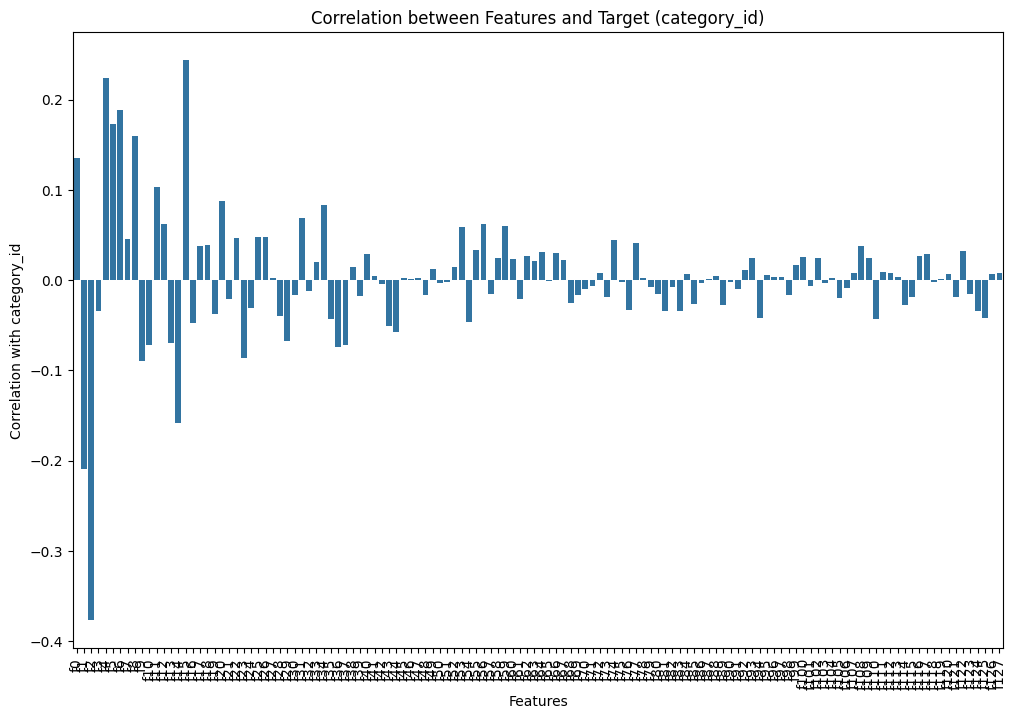

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load your dataset into a DataFrame (assuming it is stored in `df`)
# df = pd.DataFrame(...) # Assuming your dataset is already in `df`

# Select only the feature columns and target column
features = df_train.loc[:, 'f0':'f127']
target =df_train['category_id']

# Encode the category_id (you can also use one-hot encoding if needed)
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Add the encoded target to the features DataFrame
features['category_id'] = target_encoded

# Compute the correlation matrix
correlation_matrix = features.corr()

# Extract only the correlation values between features and category_id
feature_target_correlation = correlation_matrix['category_id'][:-1]  # exclude the self-correlation with `category_id`

# Plot the correlation values
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_target_correlation.index, y=feature_target_correlation.values)
plt.xticks(rotation=90)
plt.title("Correlation between Features and Target (category_id)")
plt.xlabel("Features")
plt.ylabel("Correlation with category_id")
plt.show()